In [1]:
"""Plot the 1981 data and the fit"""
from astropy import constants as c
from astropy import units as u
import numpy.ma as ma
import numpy as np
from matplotlib.collections import PatchCollection
from astropy.table import Table
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from Data import betapic_c as bp
import os, sys
import datetime
mpl.rcParams.update({'font.size': 18})

Could not save font_manager cache [Errno 28] No space left on device


finished writing out m1981model.pdf, now doing the modeling


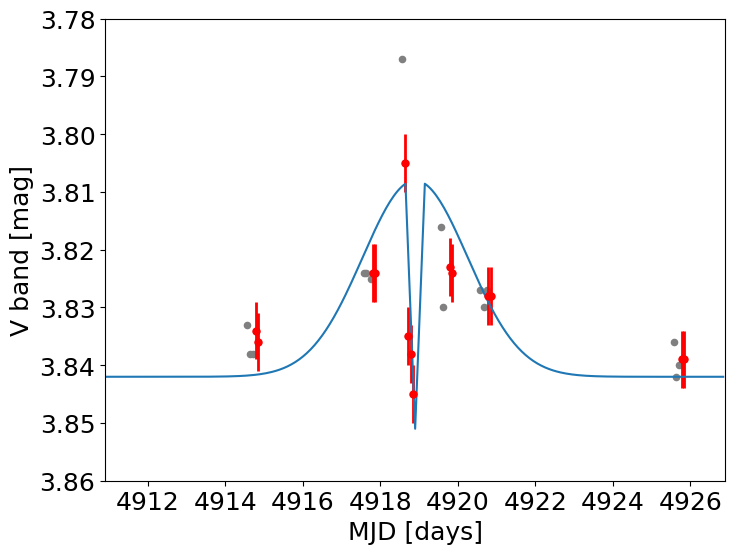

In [2]:
runtime = os.path.abspath((sys.argv[0])) + " run at " + datetime.datetime.now().strftime("%c")
tyb = dict(color='black', fontsize=20)

# choose epochs where to fit the 1981 function

# fwhm = 3.2 days is estimated from Lamers 1997 A&A 328 321 page 8 Figure 7
fwhm_lamers = 3.2

def m1981(t, t0, peak, bgnd, fwhm=fwhm_lamers, inner_width=0.25, depth=-0.009):
    """m1981 - a model for the 1981 event
    modelled with two components:
    1. a gaussian function with amplitude of `peak` and FWHM of `fwhm`
    2. narrow triangular absorption trough at the midpoint

    t - sampling points for the function
    t0 - the epoch of the central peak
    peak - amplitude of the central peak
    bgnd - the background flux level
    fwhm - full width half max of the gaussian curve
    inner_width - width of the narrow eclipser
    depth - relative depth of the narrow eclipser"""

    dt = (t-t0)

    # make the gaussian function
    
    # FWHM = 2.sqrt(2 ln 2)sig
    sig = fwhm / 2.355
    di = peak*np.exp(-dt*dt/(2*sig*sig))

    # mask central peak and replace with narrow eclipser
    mask = np.abs(dt)<inner_width
    di_edge = peak*np.exp(-inner_width*inner_width/(2*sig*sig))
    # y = mx + c
    # dt = 0, di = depth
    # dt = inner_width, di = di_edge

    m = (di_edge - depth)/(inner_width)
    di[mask] = depth + m*np.abs(dt[mask])

    di = di + bgnd
    return(di)

# Lecavelier des Etangs photometry

# leclavier des etangs 1992 AA 328 311 - Table 1
# beta pic photometry
t_lde = Table.read( """     JD          Vmag
                            4914.780    3.834
                            4914.857    3.836
                            4917.804    3.824
                            4917.857    3.824
                            4918.628    3.805
                            4918.720    3.835
                            4918.786    3.838
                            4918.856    3.845
                            4919.802    3.823
                            4919.853    3.824
                            4920.787    3.828
                            4920.859    3.828
                            4925.791    3.839
                            4925.847    3.839
                    """, format='ascii')

# The complete beta pic photometry from Lecavelier 1995
t = ascii.read('Data/lecavelierdesetangs1995/table', format='cds', 
               readme='Data/lecavelierdesetangs1995/ReadMe')
t_1981epoch = t['JD'] - 2440000.

f = plt.figure(figsize=(8,6))
ax1 = f.add_subplot(111)

# Lecavelier 1995 photometry
ax1.scatter(t_1981epoch, t['Vmag'], color='grey', s=20)

t_mid = 4919.04 # from Lecavelier des Etangs 1997
t_mid = t_mid - 0.14 # seems to be an offset I need by looking at the Lamers 1997 Figure 7

V_sigma          = 0.005 * np.ones_like(t_lde['JD']) # error quoted in Lamers 1997 Figure 1
V_mag_background = 3.842 # V band mean magnitude from Lamers 1997 Figure 1 estimate
V_1981_peak      = 0.034 # Amplitude of the broad peak model from Lamers 1997 estimated from Figure 7

ax1.errorbar(t_lde['JD'], t_lde['Vmag'], yerr=V_sigma,
             fmt='o', color='red',ecolor='red',capsize=0 ,mew=2, elinewidth=2,ms=4)
ax1.set_xlabel('MJD [days]')
ax1.set_ylabel('V band [mag]')

dt = 8. #half width of the figure plot
ax1.set_ylim(3.86,3.78)
ax1.set_xlim(t_mid-dt, t_mid+dt)

t = np.arange(t_mid-dt, t_mid+dt, 0.05)

ax1.plot(t, m1981(t, t_mid, -V_1981_peak, V_mag_background, fwhm=fwhm_lamers, depth=0.009)) # 3.842

#### ax1.text(0.98, 0.95, runtime, ha='right', va='bottom', transform=ax1.transAxes, **tyb)
#plt.title("m1981model")
plt.draw()
plt.savefig('Figures/m1981model.pdf', bbox_inches='tight')

print('finished writing out m1981model.pdf, now doing the modeling')

In [3]:
"""Make artifical time series and test that it works"""
import numpy as np
import numpy.ma as ma

step = 1.0
# mid_transits = [8210, 8707, 9413]
# t_in = np.arange(58200, 58240, step)
# t_in = np.arange(58100, 58340, step)
# read in data




def fit_1981(t, f, ferr, t_test_epochs, t_window=8.0, min_npoints=15):
    # t_window - half width of fitting window
    # min_npoints - minimum number of photometric points for a fit within the t_window
    t_test_ampl = np.zeros_like(t_test_epochs) - 1000. # set -1000 to mark bad/missing points
    t_test_ampl_err = np.zeros_like(t_test_epochs) - 1000.

    for (i, t_now) in enumerate(t_test_epochs):
        # select the points plus/minus the epoch
    #    print('Trying {:.2f} ...'.format(t_now))
        n_obs_mask = (t>(t_now-t_window)) * (t<(t_now+t_window))
        n = np.count_nonzero(n_obs_mask)
    #    print('{:d} points found'.format(n))

        if n < min_npoints:
            continue

    #    print('nonzero number of points found!')
        t_sel = t[n_obs_mask]
        d_sel = f[n_obs_mask]
        e_sel = ferr[n_obs_mask]
    #    print('t_now is {:.2f}'.format(t_now))

    # add hints and limits to the fit so it doesn't run away
        params = gmodel.make_params(t0=t_now, peak=0.1, bgnd=0.00)
        gmodel.set_param_hint('t0', value=t_now, min=t_now-(step/2.), max=t_now+(step/2.))
        gmodel.set_param_hint('peak', value=0.1, min=0.0, max=5.)

    #    print('Parameter hints:')
        #for pname, par in gmodel.param_hints.items():
        #    print(pname, par)

        result = gmodel.fit(d_sel, t=t_sel, bgnd=0.0, t0=t_now, peak=0.1)
        
        if result.success:
#            print('succeeded')
            if result.errorbars:
#                print('got me some errorbars')
                asdf = result.eval_uncertainty(sigma=3)
#                print(asdf)           
                t_test_ampl[i] = result.best_values['peak']
                t_test_ampl_err[i] = result.params['peak'].stderr

        #        print(result.params['peak'].eval_uncertainty)
        else:
            print('FAILED to fit at {}'.format(t_now))

        # convert all to masked arrays
        ama = ma.masked_less(t_test_ampl, -999)
        ema = ma.masked_less(t_test_ampl_err, -999)
        tma = np.ma.masked_where(np.ma.getmask(ama), t_test_epochs)

        
    return (tma, ama, ema)


# make artificial time series
sim_t0, sim_a, sim_bgnd = (1050, 1,0)
print('simulation values are t0={}, a={}, bgnd={}'.format(sim_t0, sim_a, sim_bgnd))
err_sim = 0.02
t_sim = np.linspace(1030, 1070, 1000)
f_sim = np.random.standard_normal(t_sim.size)*err_sim
e_sim = np.ones_like(f_sim) * err_sim
d_sim = m1981(t_sim, sim_t0, sim_a, sim_bgnd) + f_sim 

t_mock = np.linspace(1030, 1070, 1000)
data_mock = m1981(t_mock, 1040, 1,0.0) + np.random.normal(0,0.01, len(t_sim))


# basic lmfit from:
# https://lmfit.github.io/lmfit-py/model.html

from scipy.optimize import curve_fit
init_vals = [1050, 1, 0.00] #initial guess
best_vals, covar = curve_fit(m1981, t_sim, d_sim, p0=init_vals)
print('initial values into curve_fit are: {}'.format(init_vals))
print('curve_fit finds that the best fit after converging is best_vals: {}'.format(best_vals))


from lmfit import Model
gmodel = Model(m1981, param_names=('t0','peak', 'bgnd'))
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))
params = gmodel.make_params(t0=1050, peak=0.1, bgnd=0)


mlim = 0.035
t_in = np.arange(1000, 1100, 0.25)  #np.arange(59390, 59430, 0.25)
data_err = np.ones_like(data_mock)*0.01
(tmabring, amabring, emabring) = fit_1981(t_mock, data_mock,  data_err, t_in)

max_err = 0.05 # too big error bars should be zeroed out
m = (emabring>max_err)
tmabring[m] = ma.masked
amabring[m] = ma.masked
emabring[m] = ma.masked


simulation values are t0=1050, a=1, bgnd=0
initial values into curve_fit are: [1050, 1, 0.0]
curve_fit finds that the best fit after converging is best_vals: [1.04999959e+03 1.00420306e+00 3.57157963e-04]
parameter names: ['t0', 'peak', 'bgnd']
independent variables: ['t']


In [ ]:

f_bring = Table.read('Data/binned_BRING.dat', format='ascii.ecsv')
t_in = np.arange(min(f_bring['time']), max(f_bring['time']), 0.25)

#Bring Data second transit epoch 1
(tmabringf1, amabringf1, emabringf1) = fit_1981(f_bring['time'], f_bring['flux'], f_bring['ferr'], t_in)
max_err = 0.05 # too big error bars should be zeroed out
m = (emabringf1>max_err)
tmabringf1[m] = ma.masked
amabringf1[m] = ma.masked
emabringf1[m] = ma.masked

#Bring Data second transit epoch 2
t_in2 = t_in 
(tmabringf2, amabringf2, emabringf2) = fit_1981(f_bring['time'], f_bring['flux'], f_bring['ferr'], t_in2)
max_err = 0.05 # too big error bars should be zeroed out
m = (emabringf2>max_err)
tmabringf2[m] = ma.masked
amabringf2[m] = ma.masked
emabringf2[m] = ma.masked


#Brite data
f_brite = Table.read('Data/binned_BRITE.dat', format='ascii.ecsv')
(tmabrite, amabrite, emabrite) = fit_1981(f_brite['time'], f_brite['flux'], f_brite['ferr'], t_in)
m = (emabrite>max_err)
tmabrite[m] = ma.masked
amabrite[m] = ma.masked
emabrite[m] = ma.masked

#Astep
f_astep = Table.read('Data/binned_ASTEP.dat', format='ascii.ecsv')
(tmaastep, amaastep, emaastep) = fit_1981(f_astep['time'], f_astep['flux'], f_astep['ferr'], t_in)
m = (emaastep>max_err)
tmaastep[m] = ma.masked
amaastep[m] = ma.masked
emaastep[m] = ma.masked

tstack = ma.vstack([tmabrite,tmaastep,tmabringf1, tmabringf2])
astack = ma.vstack([amabrite,amaastep,amabringf1,amabringf2])
estack = ma.vstack([emabrite,emaastep,emabringf1, emabringf2])
dat = Table( [tstack, astack,estack ], names=('tstack','astack', 'estack')  )
dat.write('Data/1981_fits_Brite_Bring_astep.dat', format='ascii.ecsv', overwrite=True)

min_amp_ind = ma.argmin(estack, axis=0)
min_amp = astack[min_amp_ind,np.arange(min_amp_ind.size)]
min_tim = tstack[min_amp_ind,np.arange(min_amp_ind.size)]
min_err = estack[min_amp_ind,np.arange(min_amp_ind.size)]



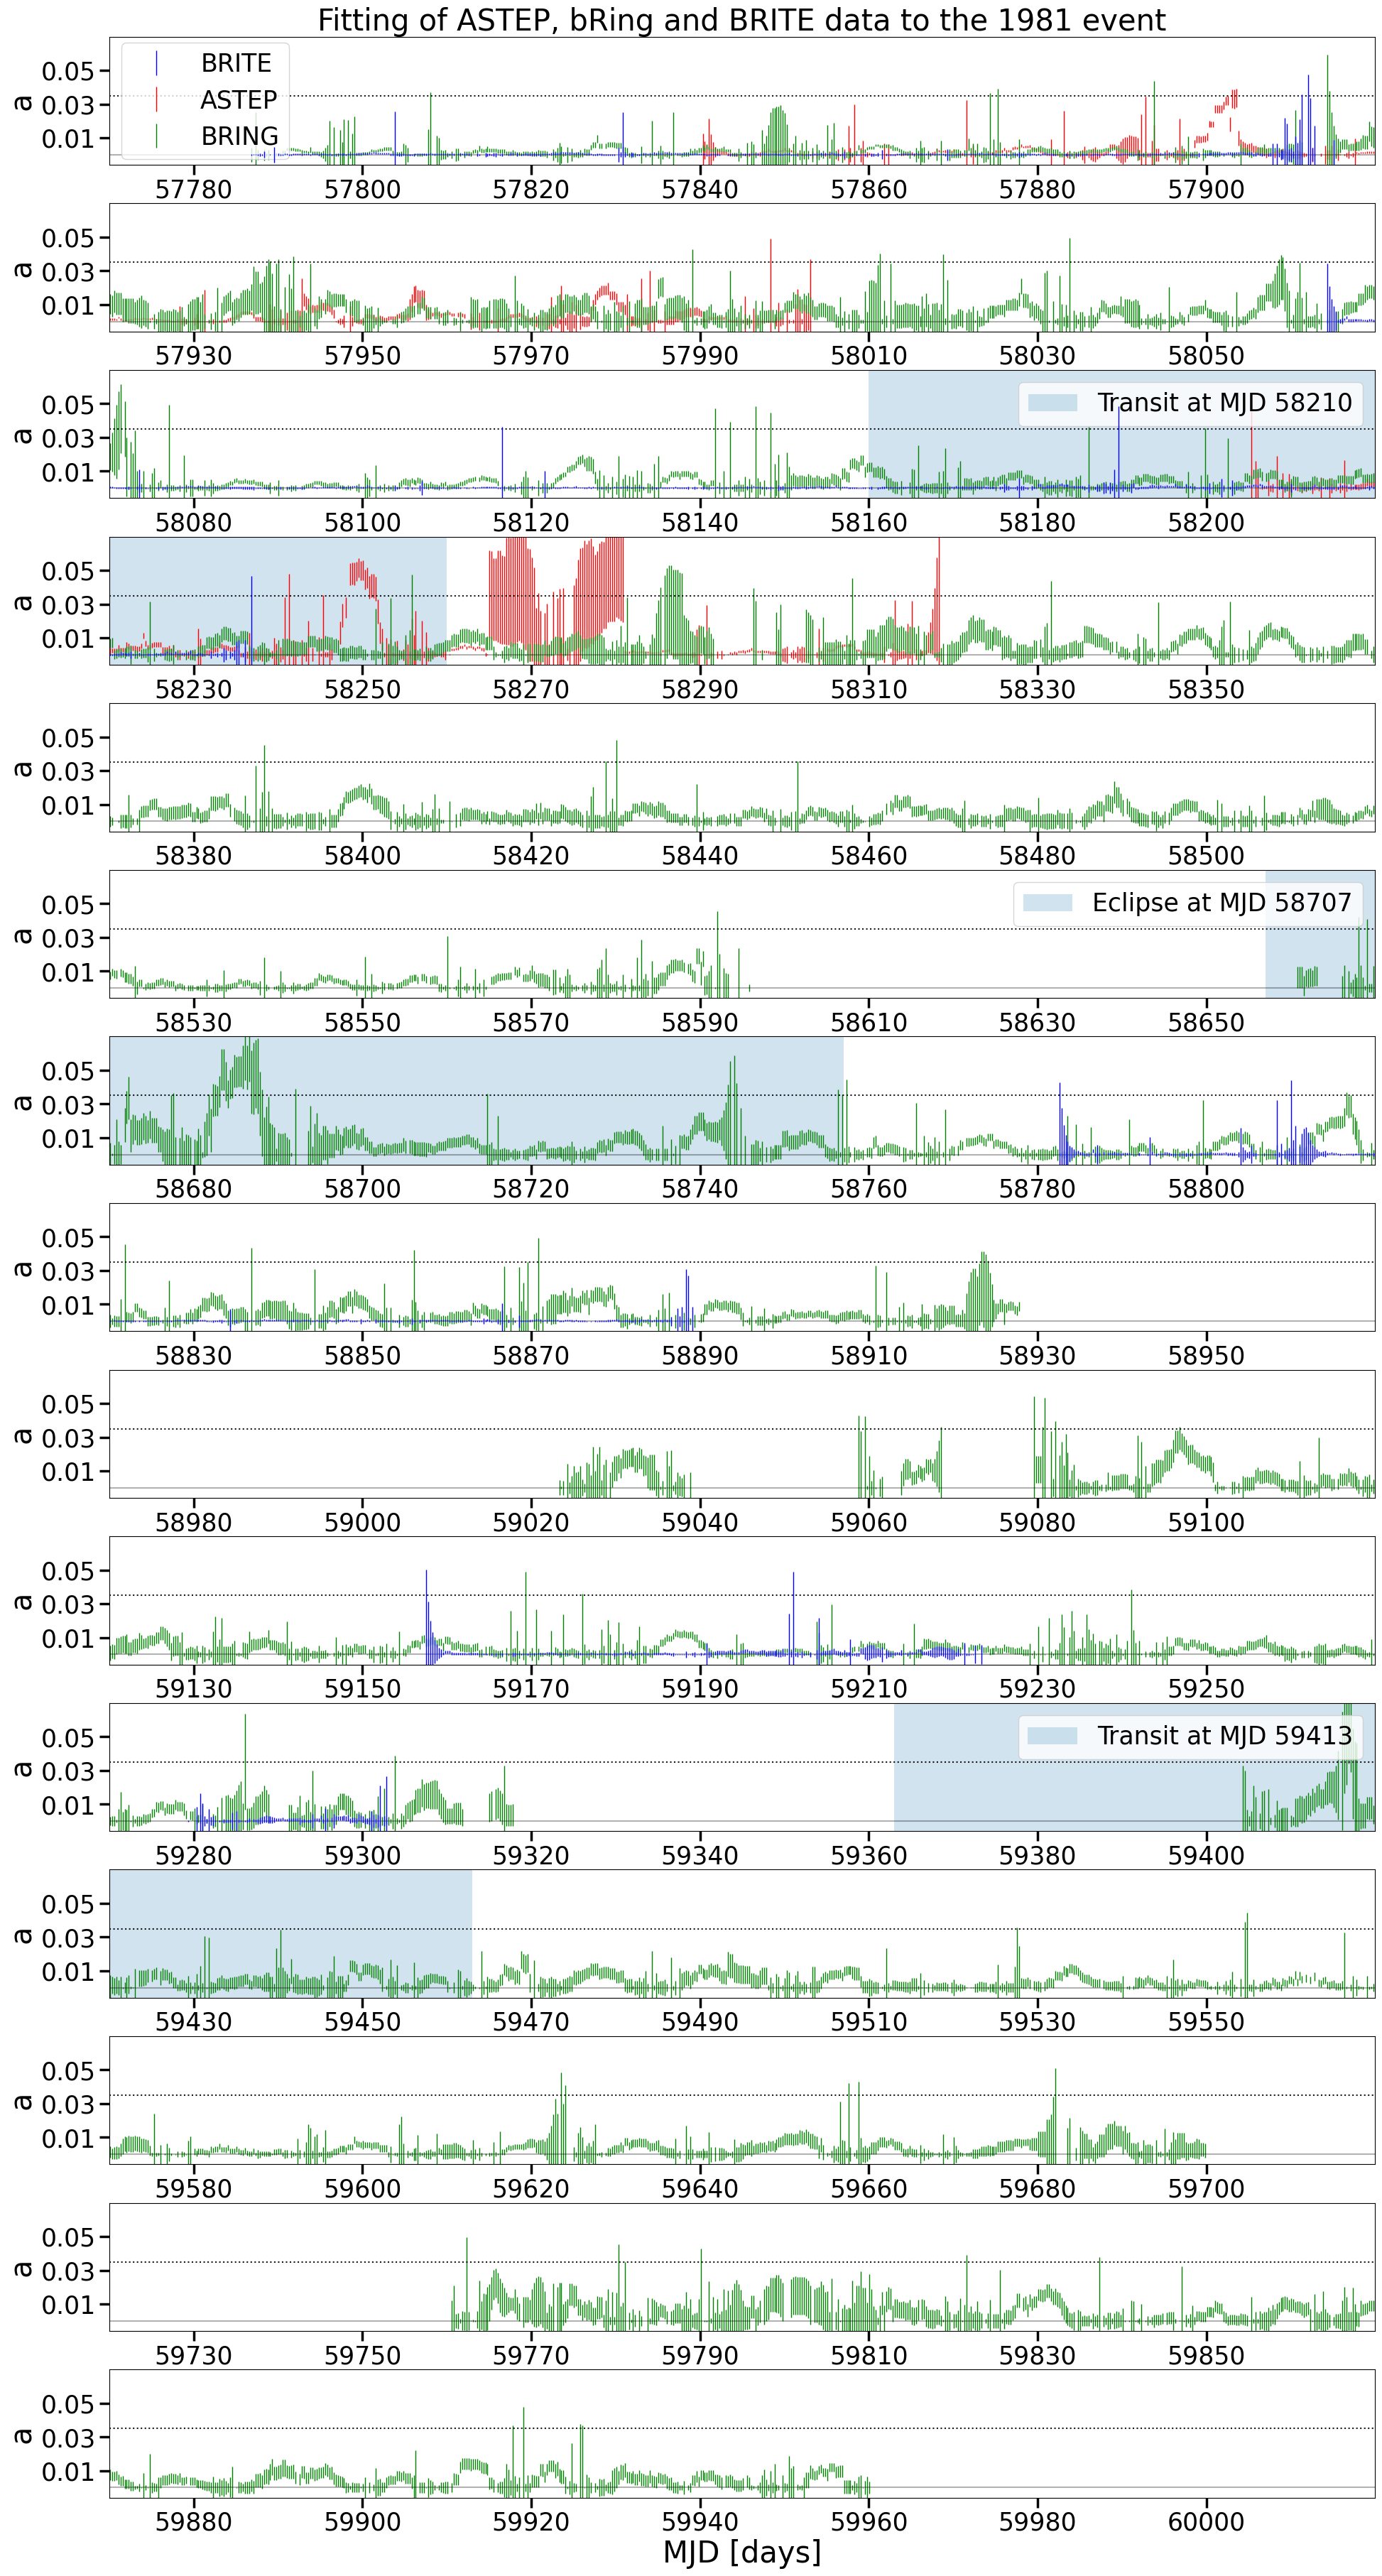

In [8]:
#plot all front eclipses
import matplotlib as mpl
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

fs = 25
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


fig6, ax = plt.subplots(15, 1, figsize=(23,45), sharex=False, sharey=False, gridspec_kw={'hspace':0.3})
ax[0].set_title("Fitting of ASTEP, bRing and BRITE data to the 1981 event", fontsize = fs+5)
start = 57770
for i in range(15):
    if i ==0:
        ax[i].errorbar(tstack[0], astack[0], yerr=np.abs(estack[0]), fmt='none', color='blue', alpha=1, label='BRITE', elinewidth=1, zorder =10)
        ax[i].errorbar(tstack[1], astack[1], yerr=np.abs(estack[1]), fmt='none', color='red', alpha=1, label='ASTEP', elinewidth=1)
        ax[i].errorbar(tstack[2], astack[2], yerr=np.abs(estack[2]), fmt='none', color='green', alpha=1, label='BRING', elinewidth=1)
    else:
        ax[i].errorbar(tstack[0], astack[0], yerr=np.abs(estack[0]), fmt='none', color='blue', alpha=1, elinewidth=1, zorder =10)
        ax[i].errorbar(tstack[1], astack[1], yerr=np.abs(estack[1]), fmt='none', color='red', alpha=1,  elinewidth=1)
        ax[i].errorbar(tstack[2], astack[2], yerr=np.abs(estack[2]), fmt='none', color='green', alpha=1, elinewidth=1)

    ax[i].set_xticks(np.arange(start+10, start+140,20), np.arange(start+10, start+140,20))
    ax[i].set_yticks([0.01, 0.03, 0.05], [0.01, 0.03, 0.05])


    ax[i].tick_params(axis='both', which='major', labelsize=fs, width=2.5, length=10)
    ax[i].set_ylim(-0.006,0.07)
    ax[i].axhline(0, color='black', alpha=0.3)
    ax[i].axhline(mlim, color='black', alpha=0.9, linestyle='dotted')
    ax[i].set_xlim(start, start+150)
    ax[i].set_ylabel("a",fontsize=fs+5)
    start +=150
ax[0].legend(loc='center left', fontsize = fs)

ax[2].axvspan(58160, 58260, alpha=0.2, label = 'Transit at MJD 58210')
ax[2].legend(loc='upper right', fontsize =fs)
ax[3].axvspan(58160, 58260, alpha=0.2)
ax[5].axvspan(58657, 58757, alpha=0.2, label = 'Eclipse at MJD 58707')
ax[5].legend(loc='upper right', fontsize =fs)
ax[6].axvspan(58657, 58757, alpha=0.2)
ax[10].axvspan(59363, 59463, alpha=0.2, label = 'Transit at MJD 59413')
ax[10].legend(loc='upper right', fontsize =fs)
ax[11].axvspan(59363, 59463, alpha=0.2)

ax[14].set_xlabel('MJD [days]',fontsize=fs+5)
plt.savefig('Figures/1981_fits.pdf', bbox_inches='tight', dpi=700)
plt.show()
